In [209]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, LinearGaussianBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDsScore
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination
import networkx as nx

In [210]:
def visualise(model, pos, projectile_color="skyblue", interceptor_color="lightcoral"):
    edges = model.edges()

    # Create a directed graph object
    G = nx.DiGraph()

    # Add edges to the graph
    G.add_edges_from(edges)

    # Create a color map based on node type
    color_map = []
    for node in G.nodes():
        if "P_" in node:
            color_map.append(projectile_color)
        elif "I_" in node:
            color_map.append(interceptor_color)
        else:
            color_map.append("gray")  # Default color for any other nodes

    # Plot the graph with custom positions and colors
    plt.figure(figsize=(20, 12))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=color_map, font_size=8, font_weight="bold", arrowsize=10)
    plt.title("Bayesian Network Graph")
    plt.show()

In [211]:
# Define positions manually without direction and angle values
pos = {}

for i in range(6):
    if i % 2 == 0:
        # Projectile nodes positions (lower row)
        pos[f'P_FP{i}'] = (i * 3 - 1, 0)            # Final position
        pos[f'P_V{i}'] = (i * 3 + 1, -1)        # Velocity
        pos[f'P_IP{i}'] = (i * 3 - 1, -1)       # Initial position

        # Interceptor nodes positions (upper row)
        pos[f'I_FP{i}'] = (i * 3 - 1, 3)            # Final position
        pos[f'I_V{i}'] = (i * 3 + 1, 2)         # Velocity
        pos[f'I_IP{i}'] = (i * 3 - 1, 2)        # Initial position
    else:
        # Projectile nodes positions (lower row)
        pos[f'P_FP{i}'] = (i * 3 - 1, -1)           # Final position
        pos[f'P_V{i}'] = (i * 3 + 1, -2)        # Velocity
        pos[f'P_IP{i}'] = (i * 3 - 1, -2)       # Initial position

        # Interceptor nodes positions (upper row)
        pos[f'I_FP{i}'] = (i * 3 - 1, 4)            # Final position
        pos[f'I_V{i}'] = (i * 3 + 1, 3)         # Velocity
        pos[f'I_IP{i}'] = (i * 3 - 1, 3)        # Initial position


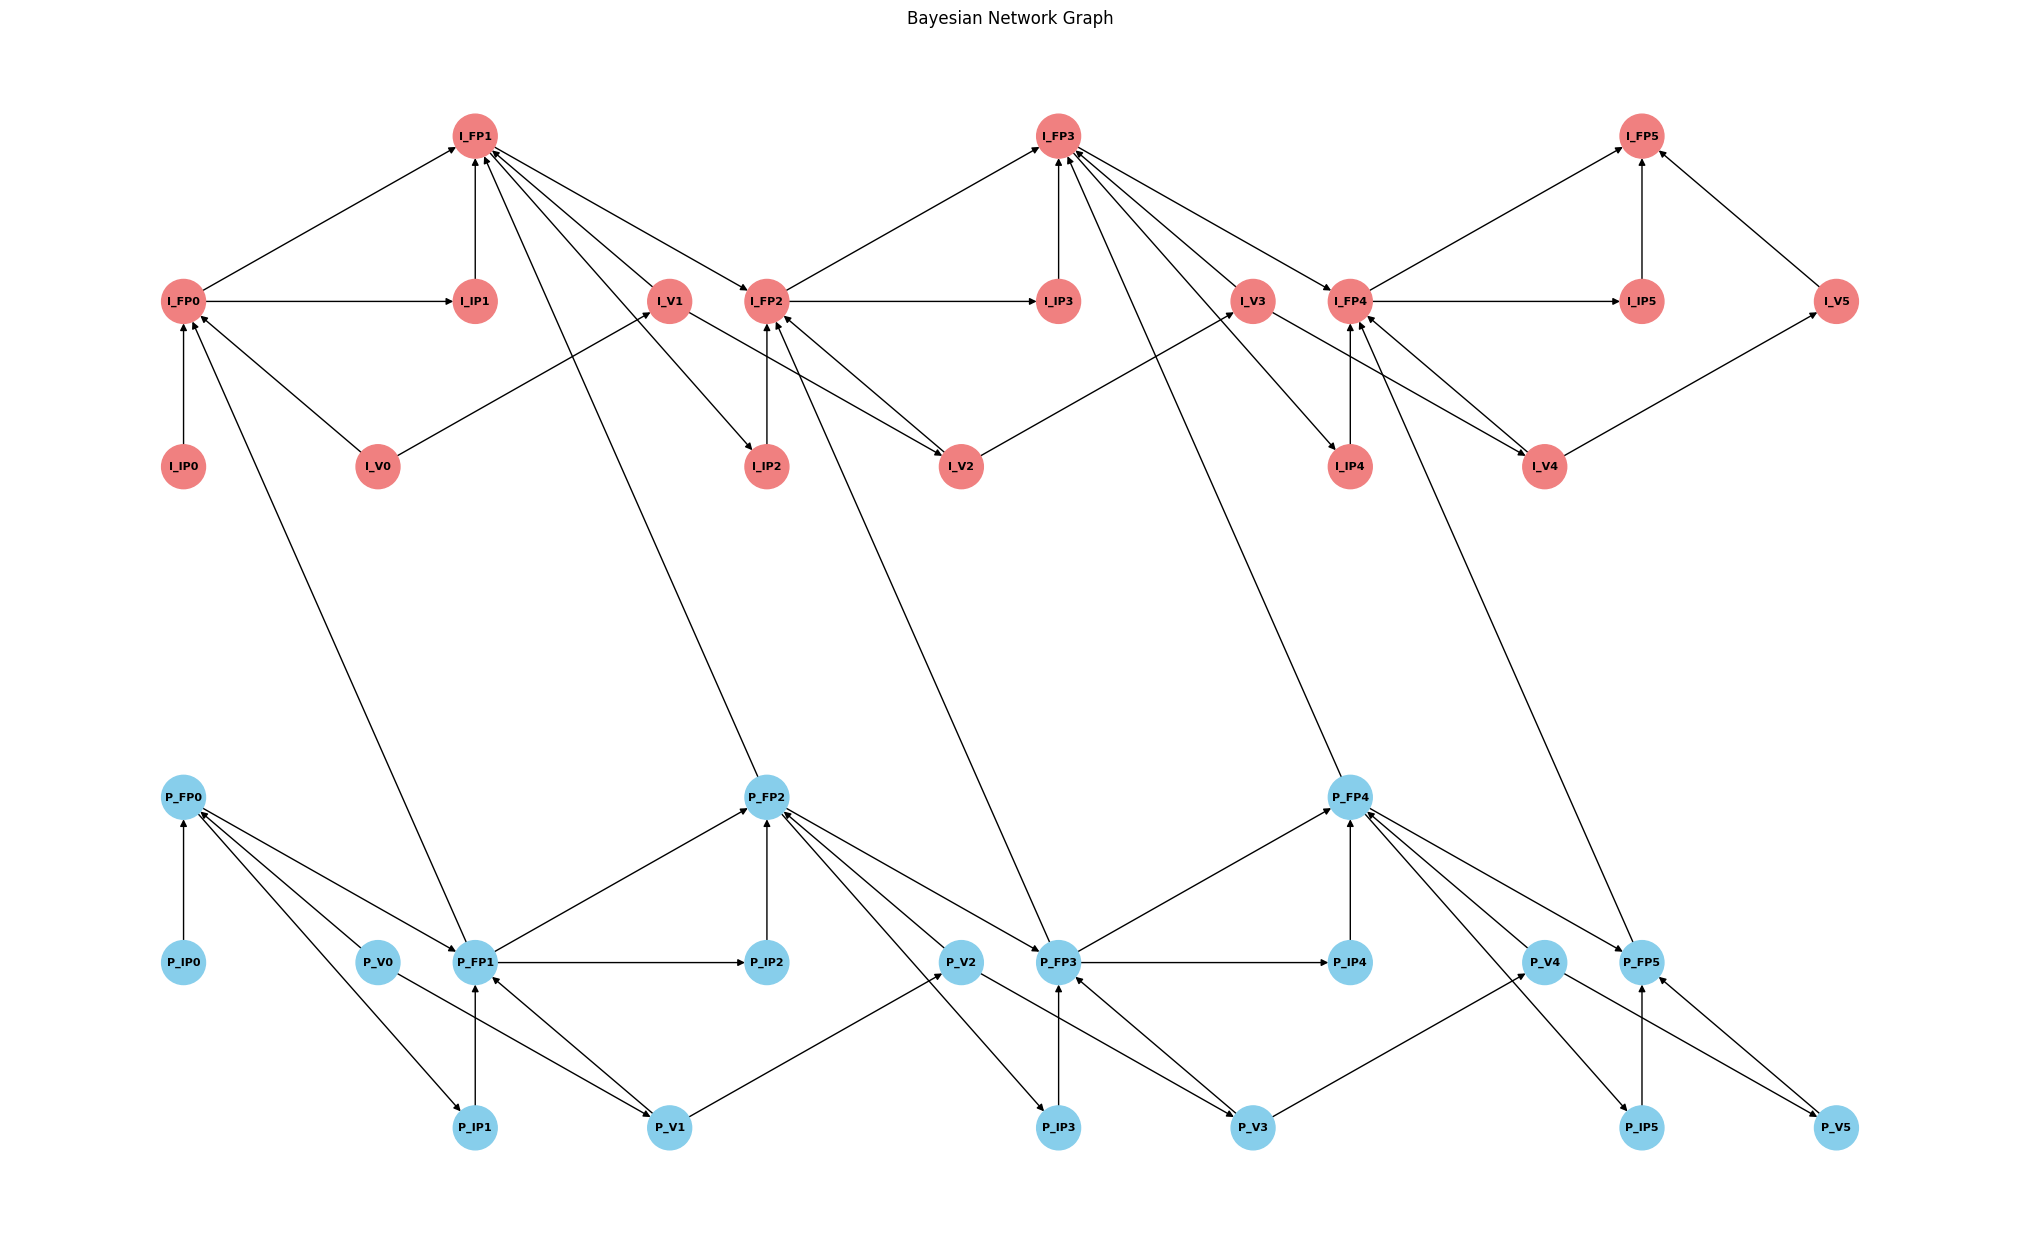

In [212]:
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork

# Initialize the Bayesian Network model
GT = LinearGaussianBayesianNetwork()

for i in range(6):
    # Add nodes for final position (FP), velocity (V), and initial position (IP)
    GT.add_nodes_from([
        f'P_FP{i}', f'P_V{i}', f'P_IP{i}',  # Projectile nodes
        f'I_FP{i}', f'I_V{i}', f'I_IP{i}'   # Interceptor nodes
    ])
    
    # Add edges within each time slice
    GT.add_edges_from([
        (f'P_IP{i}', f'P_FP{i}'),  # Initial position influences final position
        (f'P_V{i}', f'P_FP{i}'),   # Velocity influences final position
        (f'I_IP{i}', f'I_FP{i}'),  # Initial position influences final position
        (f'I_V{i}', f'I_FP{i}')    # Velocity influences final position
    ])

    if i < 5:
        # Connect corresponding nodes between time slices for projectile and interceptor
        GT.add_edges_from([
            (f'P_FP{i}', f'P_FP{i + 1}'),
            (f'P_FP{i}', f'P_IP{i + 1}'),
            (f'P_V{i}', f'P_V{i + 1}'),
            # (f'P_IP{i}', f'P_IP{i + 1}'),
            (f'I_FP{i}', f'I_FP{i + 1}'),
            (f'I_FP{i}', f'I_IP{i + 1}'),
            (f'I_V{i}', f'I_V{i + 1}'),
            # (f'I_IP{i}', f'I_IP{i + 1}')
        ])
        
        # Edge between projectile and interceptor across time slices
        GT.add_edge(f'P_FP{i + 1}', f'I_FP{i}')

# Visualize the updated Bayesian Network structure
visualise(GT, pos)



In [213]:

for i in range(6):
    if i == 0:
       
        cpd_P_FP = LinearGaussianCPD(
            f'P_FP{i}', 
            [0.0, 1, 1], 
            2.0, 
            [f'P_V{i}', f'P_IP{i}']  
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{i}', 
            [20.0],  
            10.0, 
            [] 
        )

        cpd_P_IP = LinearGaussianCPD(
            f'P_IP{i}',
            [1000.0],  
            3000,
            [] 
        )

    else:
       
        cpd_P_FP = LinearGaussianCPD(
            f'P_FP{i}', 
            [0.0, 1, 1, 1],  
            2.0, 
            [f'P_V{i}', f'P_FP{i - 1}', f'P_IP{i}'] 
        )

        cpd_P_V = LinearGaussianCPD(
            f'P_V{i}', 
            [20.0, 1],  
            5.0, 
            [f'P_V{i - 1}'] 
        )

        cpd_P_IP = LinearGaussianCPD(
            f'P_IP{i}',
            [0.0, 1],  
            3,
            [f'P_FP{i - 1}']  
        )

    
    GT.add_cpds(cpd_P_FP, cpd_P_V, cpd_P_IP)



for i in range(6):
    if i == 0:
        
        if i < 5:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [0.0, 1, 1, 1],  
                3.0, 
                [f'P_FP{i+1}', f'I_IP{i}', f'I_V{i}']  
            )
        else:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [0.0, 1, 1],  
                3.0, 
                [f'I_IP{i}', f'I_V{i}']  
            )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{i}', 
            [20.0],  
            10.0, 
            []  
        )

        cpd_I_IP = LinearGaussianCPD(
            f'I_IP{i}',
            [0.0],  
            0.0,
            []  
        )

    else:
        
        if i < 5:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [0.0, 1, 1, 1, 1], 
                3.0, 
                [f'P_FP{i+1}', f'I_FP{i - 1}', f'I_IP{i}', f'I_V{i}'] 
            )
        else:
            cpd_I_FP = LinearGaussianCPD(
                f'I_FP{i}', 
                [0.0, 1, 1, 1],  
                3.0, 
                [f'I_FP{i - 1}', f'I_IP{i}', f'I_V{i}'] 
            )

        cpd_I_V = LinearGaussianCPD(
            f'I_V{i}', 
            [20.0, 1],  
            5.0, 
            [f'I_V{i - 1}']  
        )

        cpd_I_IP = LinearGaussianCPD(
            f'I_IP{i}',
            [0.0, 1], 
            0.5,
            [ f'I_FP{i - 1}']  
        )

    # Add CPDs to the network
    GT.add_cpds(cpd_I_FP, cpd_I_V, cpd_I_IP)


In [214]:
# Validation
if GT.check_model():
    print("The model is valid!")
else:
    print("The model is not valid. Please check the CPDs and network structure.")


The model is valid!


In [215]:
import numpy as np
import pandas as pd
from pgmpy.models import LinearGaussianBayesianNetwork

def get_topological_order(model):
    """
    Function to return nodes of the Bayesian Network in topological order.
    """
    nodes = list(model.nodes())
    order = []
    visited = set()
    
    def visit(node):
        if node not in visited:
            visited.add(node)
            for parent in model.get_parents(node):
                visit(parent)
            order.append(node)
    
    for node in nodes:
        visit(node)
    
    return order

def sample_from_lgbn(model, n_samples=1000):
    """Perform forward sampling from a Linear Gaussian Bayesian Network."""
    # topological_order = list(model.nodes())
    topological_order = get_topological_order(model)
    print(topological_order)
    # Initialize an empty DataFrame for storing samples
    samples_df = pd.DataFrame(index=range(n_samples), columns=topological_order)

    for node in topological_order:
        cpd = model.get_cpds(node)

        # Mean and variance of the CPD
        mean = np.array(cpd.mean).flatten()
        variance = np.array(cpd.variance).flatten()

        if len(mean) != 1 and len(variance) != 1:
            raise ValueError(f"Mean and variance for node {node} must be scalar or match dimensions.")

        if not cpd.evidence:
            # Node has no parents, sample directly
            samples_df[node] = np.random.normal(loc=mean[0], scale=np.sqrt(variance), size=n_samples)
        else:
            # Ensure parent columns are converted to float
            parent_values = samples_df[cpd.evidence].astype(float).values
            # Reshape parent_values to ensure it matches dimensions
            if parent_values.shape[1] != len(mean[1:]):
                print(cpd.variables)
                raise ValueError(f"Number of parent columns ({parent_values.shape[1]}) does not match the number of coefficients ({len(mean[1:])}).")
            
            # Calculate the mean based on the parent's sampled values
            parent_mean = np.dot(parent_values, mean[1:]) + mean[0]
            # Sample from the Gaussian distribution
            samples_df[node] = np.random.normal(loc=parent_mean, scale=np.sqrt(variance), size=n_samples)

    return samples_df

# Example usage:
n_samples = 1000
samples_df = sample_from_lgbn(GT, n_samples=n_samples)

# Save to CSV
samples_df.to_csv("trajectory_data.csv", index=False)
print(f"Generated {n_samples} samples and saved to trajectory_data.csv")




['P_IP0', 'P_V0', 'P_FP0', 'I_IP0', 'I_V0', 'P_IP1', 'P_V1', 'P_FP1', 'I_FP0', 'I_IP1', 'I_V1', 'P_IP2', 'P_V2', 'P_FP2', 'I_FP1', 'I_IP2', 'I_V2', 'P_IP3', 'P_V3', 'P_FP3', 'I_FP2', 'I_IP3', 'I_V3', 'P_IP4', 'P_V4', 'P_FP4', 'I_FP3', 'I_IP4', 'I_V4', 'P_IP5', 'P_V5', 'P_FP5', 'I_FP4', 'I_IP5', 'I_V5', 'I_FP5']
Generated 1000 samples and saved to trajectory_data.csv


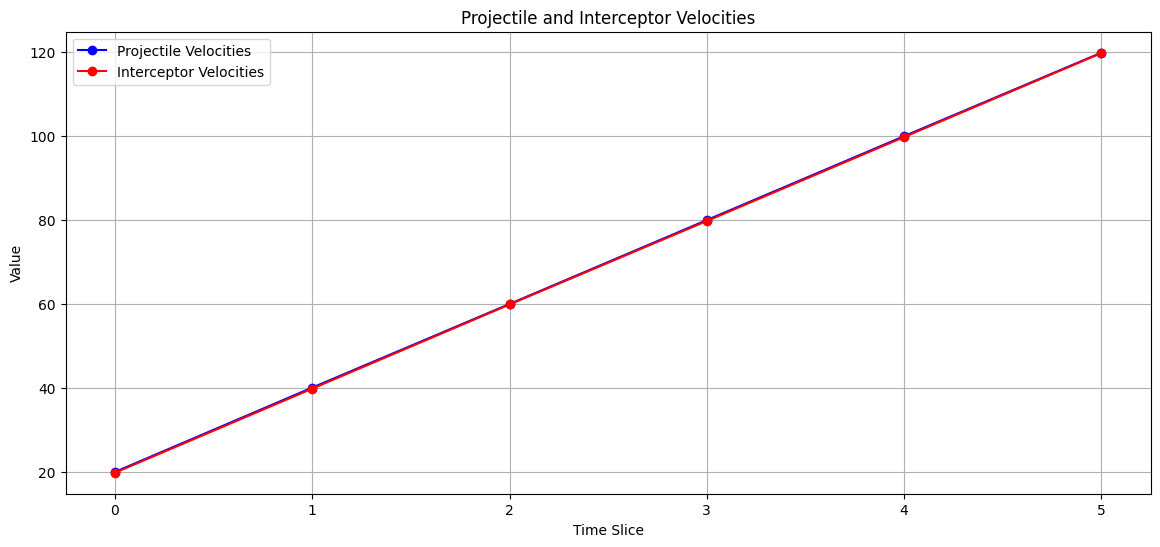

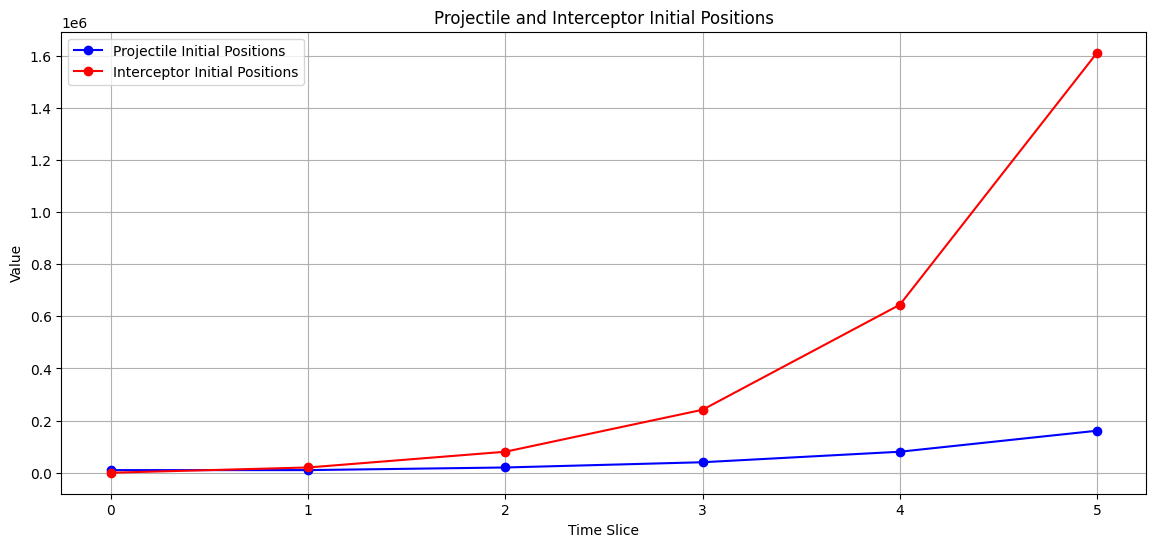

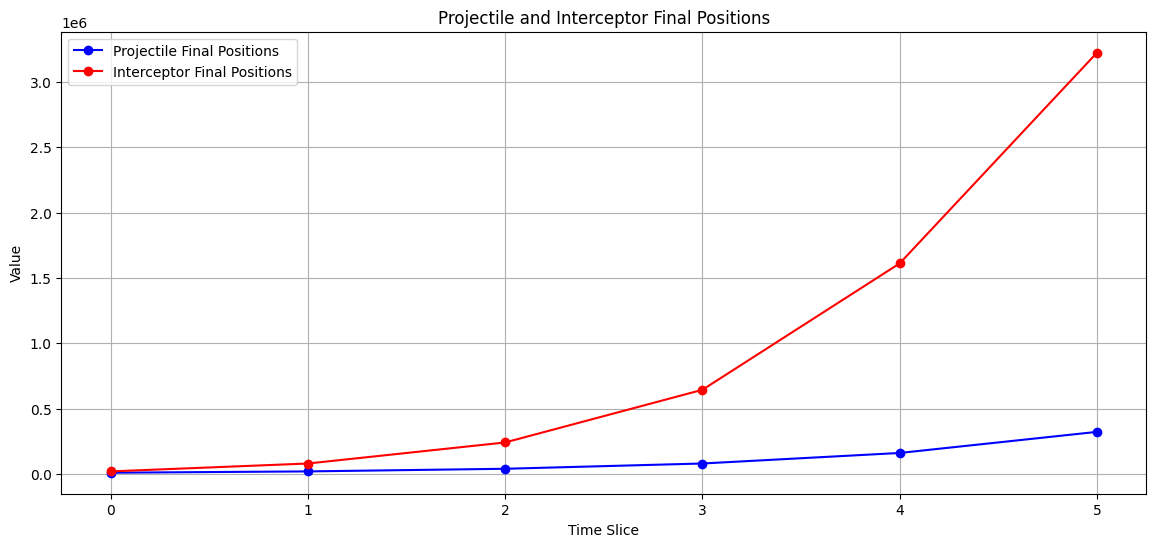

            P_FP0         P_FP1         P_FP2         P_FP3          P_FP4  \
0    10034.594645  20110.901204  40279.904583  80643.465926  161388.228892   
1     9936.551320  19905.617998  39862.265126  79787.997911  159663.695896   
2    10074.863743  20190.110569  40438.828035  80950.587644  161993.180895   
3    10048.309027  20140.886345  40345.264132  80774.095063  161648.981007   
4    10104.930156  20253.146940  40576.507641  81238.202094  162581.184492   
..            ...           ...           ...           ...            ...   
995   9977.343540  19999.418453  40055.333358  80186.903627  160471.162442   
996  10009.378021  20057.751712  40180.504403  80447.416579  161003.171173   
997  10002.099574  20051.627414  40166.832215  80416.360027  160939.230418   
998  10029.249989  20099.130015  40258.471567  80595.962931  161291.148080   
999  10069.481833  20175.593556  40411.012698  80901.527247  161899.959131   

             P_FP5  
0    322900.702494  
1    319435.059613  


In [216]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
file_path = 'trajectory_data.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Convert all columns to numeric, forcing non-numeric values to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Define time slices
time_slices = [0, 1, 2, 3, 4, 5]

# Define columns to plot for velocities and angles
projectile_velocities = ['P_V0', 'P_V1', 'P_V2', 'P_V3', 'P_V4', 'P_V5']
interceptor_velocities = ['I_V0', 'I_V1', 'I_V2', 'I_V3', 'I_V4', 'I_V5']
# projectile_angles = ['P_A0', 'P_A1', 'P_A2', 'P_A3', 'P_A4', 'P_A5']
# interceptor_angles = ['I_A0', 'I_A1', 'I_A2', 'I_A3', 'I_A4', 'I_A5']
projectile_ips = [f'P_IP{i}' for i in range(6)]
projectile_fps = [f'P_FP{i}' for i in range(6)]
# projectile_ds = [f'P_D{i}' for i in range(6)]
interceptor_ips = [f'I_IP{i}' for i in range(6)]
interceptor_fps = [f'I_FP{i}' for i in range(6)]
# interceptor_ds = [f'I_D{i}' for i in range(6)]

# Function to plot velocities or angles
def plot_values(data, projectile_columns, interceptor_columns, title, label):
    plt.figure(figsize=(14, 6))
    
    # Plot projectile velocities
    plt.plot(time_slices, data[projectile_columns].mean(axis=0), marker='o', label='Projectile ' + label, color='blue')
    
    # Plot interceptor velocities
    plt.plot(time_slices, data[interceptor_columns].mean(axis=0), marker='o', label='Interceptor ' + label, color='red')
    
    plt.xlabel('Time Slice')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# Plot velocities for projectile and interceptor
plot_values(data, projectile_velocities, interceptor_velocities, 'Projectile and Interceptor Velocities', "Velocities")
plt.show()

# Plot velocities for projectile and interceptor
plot_values(data, projectile_ips, interceptor_ips, 'Projectile and Interceptor Initial Positions', "Initial Positions")
plt.show()

# Plot angles for projectile and interceptor
plot_values(data, projectile_fps, interceptor_fps, 'Projectile and Interceptor Final Positions', "Final Positions")
plt.show()

print(data[projectile_fps])
print(data[projectile_ips])
